In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import numpy as np
import tensorflow as tf

In [11]:
df = pd.read_csv("bird_songs_metadata.csv")
df.head(2)

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav


In [12]:
class_names = df["name"].unique()
print(class_names)

["Bewick's Wren" 'Northern Mockingbird' 'American Robin' 'Song Sparrow'
 'Northern Cardinal']


In [13]:
df["name"].value_counts()

name
Song Sparrow            1256
Northern Mockingbird    1182
Northern Cardinal       1074
American Robin          1017
Bewick's Wren            893
Name: count, dtype: int64

<BarContainer object of 5 artists>

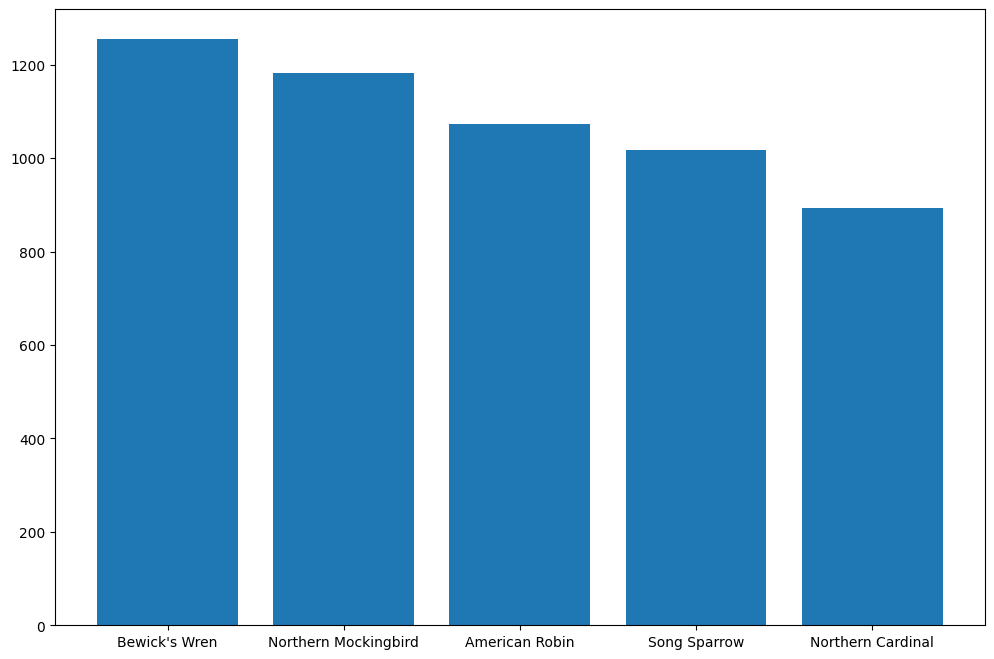

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(df["name"].unique(), df["name"].value_counts())

In [15]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [16]:
path_to_wav = "wavfiles/"


In [17]:
df_train = pd.DataFrame({"name": df["name"], "audiopath": path_to_wav + df["filename"]})

In [18]:
df_train["mfccs_scaled_features"] = df_train["audiopath"].apply(lambda x: features_extractor(x))

In [19]:
df_train["class"] = df_train["name"].factorize()[0]


In [20]:
from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_train.shape

(5422, 4)

In [21]:
(train_x, train_y) = df_train["mfccs_scaled_features"][:5000].values, df_train["class"][:5000].values
(test_x, test_y) = df_train["mfccs_scaled_features"][5000:].values, df_train["class"][5000:].values

In [22]:
from keras.utils import to_categorical

test_y = to_categorical(test_y, num_classes=len(class_names))
train_y = to_categorical(train_y, num_classes=len(class_names))

In [23]:
train_x = np.stack(train_x[:])
test_x = np.stack(test_x[:])

train_x = tf.keras.utils.normalize(train_x)
test_x = tf.keras.utils.normalize(test_x)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [24]:
train_x

array([[-9.39625263e-01,  2.13235065e-01, -1.59667090e-01, ...,
        -2.18557217e-03,  1.43336328e-02,  5.68661373e-03],
       [-9.82911229e-01, -1.20876236e-02, -1.14133865e-01, ...,
        -4.91501123e-04,  5.88002335e-03, -2.99082976e-03],
       [-9.82163250e-01,  8.72182325e-02, -2.44642943e-02, ...,
        -4.79284069e-03,  1.38140032e-02, -7.42887473e-03],
       ...,
       [-6.57373607e-01,  4.98357147e-01,  2.96554901e-02, ...,
         7.03334901e-03,  2.31679436e-02, -8.14879965e-03],
       [-5.95910311e-01, -6.09553158e-01, -4.88016307e-01, ...,
         1.21540558e-02, -7.98020512e-03,  1.18428962e-02],
       [-9.18960750e-01, -3.00251156e-01, -2.03702882e-01, ...,
         2.83919880e-03, -4.60515684e-03,  2.02041529e-02]], dtype=float32)

In [25]:
train_dataset = train_dataset.batch(10)
test_dataset = test_dataset.batch(10)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [26]:
train_x.shape

(5000, 40)

In [27]:
import keras
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Reshape, InputLayer, Dropout,Activation
from keras.models import Sequential

In [28]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(5))
model.add(Activation('softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [30]:
model.compile('adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), 'accuracy'])

In [31]:
classifier = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
500/500 [==============================] - 5s 5ms/step - loss: 1.4244 - recall: 0.0368 - precision: 0.5041 - accuracy: 0.3264 - val_loss: 1.1965 - val_recall: 0.0190 - val_precision: 0.8000 - val_accuracy: 0.4526
Epoch 2/50
500/500 [==============================] - 3s 5ms/step - loss: 1.1736 - recall: 0.1646 - precision: 0.5606 - accuracy: 0.4570 - val_loss: 1.0411 - val_recall: 0.2133 - val_precision: 0.7438 - val_accuracy: 0.5592
Epoch 3/50
500/500 [==============================] - 3s 7ms/step - loss: 1.0768 - recall: 0.2762 - precision: 0.5892 - accuracy: 0.5038 - val_loss: 1.0195 - val_recall: 0.3223 - val_precision: 0.6974 - val_accuracy: 0.5687
Epoch 4/50
500/500 [==============================] - 3s 6ms/step - loss: 1.0290 - recall: 0.3374 - precision: 0.6250 - accuracy: 0.5300 - val_loss: 0.9676 - val_recall: 0.3697 - val_precision: 0.7393 - val_accuracy: 0.5924
Epoch 5/50
500/500 [==============================] - 3s 6ms/step - loss: 0.9979 - recall: 0.3648 - prec

In [32]:
model.save("model.h5")  # Save model

In [33]:
print(model.metrics_names)

['loss', 'recall', 'precision', 'accuracy']


In [34]:
pred_y = model.predict(test_x)
true_y = test_y.argmax(axis=1, keepdims=True)

14/14 [==============================] - 0s 2ms/step


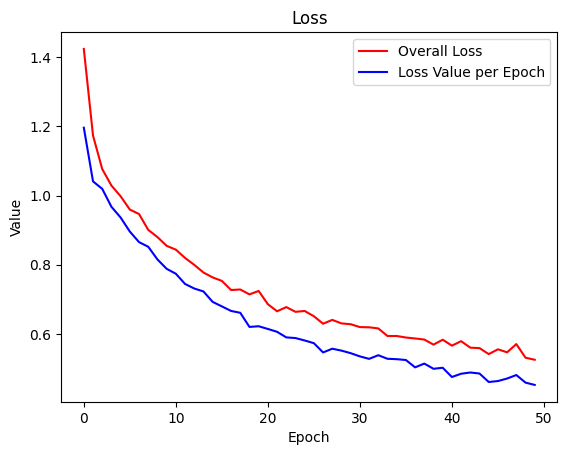

In [35]:
plt.title('Loss')
plt.plot(classifier.history['loss'], 'r', label='Overall Loss')
plt.plot(classifier.history['val_loss'], 'b', label='Loss Value per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

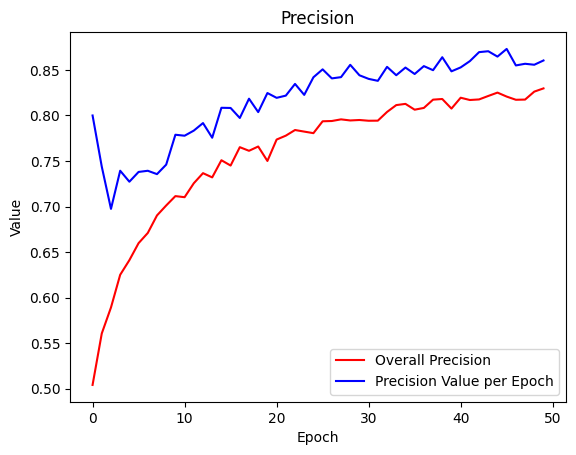

In [39]:
plt.title('Precision')
plt.plot(classifier.history['precision'], 'r', label='Overall Precision')
plt.plot(classifier.history['val_precision'], 'b', label='Precision Value per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [40]:
#manual testing for random
audio_file = 'wavfiles/111649-2.wav'
feature = features_extractor(audio_file)
mfccs_scaled_features=feature.reshape(1,-1)
normalized_data = tf.keras.utils.normalize(mfccs_scaled_features)

bird_list = ["Bewick's Wren", "Northern Mockingbird", "American Robin", "Song Sparrow", "Northern Cardinal"]

test=model.predict(normalized_data)
predicted_class = np.argmax(test, axis=1)
print(predicted_class)
predicted_bird = bird_list[predicted_class[0]]
print(predicted_bird)
# print(test[0][0])

# print(test)

1/1 [==============================] - 0s 21ms/step
[3]
Song Sparrow
